## BBC Experiment [Part 5 - Cleaned Basic Segmentation Bro]

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from fastai.vision import *
from pathlib import Path
import pandas as pd
import json

In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [4]:
path=Path('../data/bbc_train')

In [5]:
path.ls()

[PosixPath('../data/bbc_train/train.json'),
 PosixPath('../data/bbc_train/train_classification_labels.csv'),
 PosixPath('../data/bbc_train/.DS_Store'),
 PosixPath('../data/bbc_train/train_masks'),
 PosixPath('../data/bbc_train/train')]

In [6]:
fnames = get_image_files(path/'train')
fnames[:3]

[PosixPath('../data/bbc_train/train/P2050886.jpg'),
 PosixPath('../data/bbc_train/train/P2050729.jpg'),
 PosixPath('../data/bbc_train/train/P2050513.jpg')]

In [7]:
lbl_names = get_image_files(path/'train_masks')
lbl_names[:3]

[PosixPath('../data/bbc_train/train_masks/P2050393.png'),
 PosixPath('../data/bbc_train/train_masks/P2050807.png'),
 PosixPath('../data/bbc_train/train_masks/P2050940.png')]

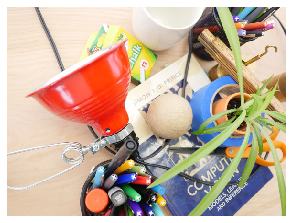

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [9]:
def get_y_fn(x): return path/'train_masks'/(x.stem + '.png')
classes = array(['background', 'brick', 'ball', 'cylinder'])

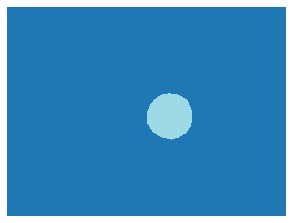

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
unique(mask.data)

array([0, 2])

In [12]:
src = (SegmentationItemList.from_folder(path/'train')
       .split_by_rand_pct(0.2)
       .label_from_func(get_y_fn, classes=classes))

In [13]:
data = (src.transform(get_transforms(), tfm_y=True, size=(256,256))
        .databunch(bs=16)
        .normalize(imagenet_stats))

In [14]:
data

ImageDataBunch;

Train: LabelList (754 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Valid: LabelList (188 items)
x: SegmentationItemList
Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256),Image (3, 256, 256)
y: SegmentationLabelList
ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256),ImageSegment (1, 256, 256)
Path: ../data/bbc_train/train;

Test: None

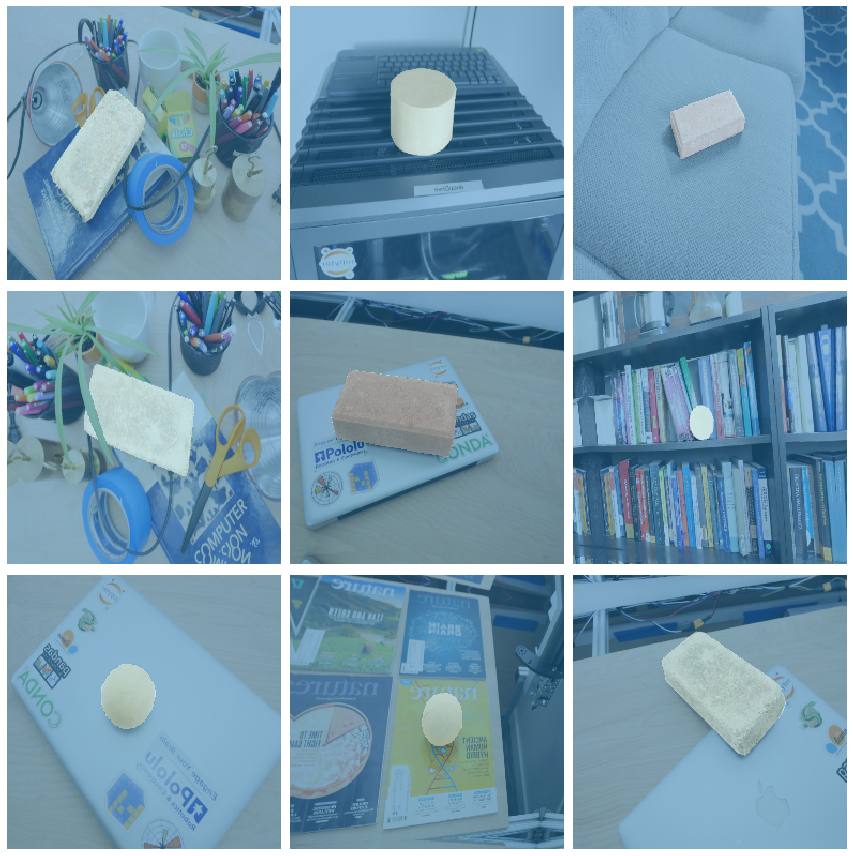

In [15]:
data.show_batch(3, figsize=(12,12))

- BatchNorm2d          [512, 8, 8]
- How can we build this up back to a full image?
- In my lecture, I should be able to borrow some from my GAN lecture on **transposed convolutions**: https://github.com/stephencwelch/dl-workshop/blob/master/generative_adversarial_networks/Generative%20Adversarial%20Networks.ipynb


In [16]:
def conv_trans(ni, nf, ks = 4, stride = 2, padding = 1):
    return nn.Sequential(
        nn.ConvTranspose2d(ni, nf, kernel_size=ks, bias=False, stride=stride, padding = padding), 
        nn.ReLU(inplace = True), 
        nn.BatchNorm2d(nf))

In [17]:
custom_head=nn.Sequential(conv_trans(512, 256), 
                          conv_trans(256, 128),
                          conv_trans(128, 64),
                          conv_trans(64, 32), 
                          nn.ConvTranspose2d(32, 4, kernel_size=4, bias=False, stride=2, padding = 1))

In [27]:
def pixel_accuracy(yhat, y):
    y_=y.squeeze(dim=1)
    yhat_=yhat.argmax(dim=1)
    return (y_==yhat_).sum().float()/y.numel()

In [28]:
learn=cnn_learner(data, models.resnet18, custom_head=custom_head, metrics=pixel_accuracy)

In [29]:
learn.freeze()

In [22]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


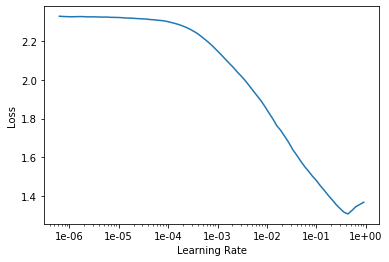

In [24]:
learn.recorder.plot()

In [31]:
lr=1e-2
learn.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.827104,0.588146,0.869937,00:15
1,0.336191,0.149713,0.950848,00:14
2,0.187115,0.081703,0.969288,00:14
3,0.123680,0.074710,0.971509,00:13


In [32]:
learn.unfreeze()

In [33]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


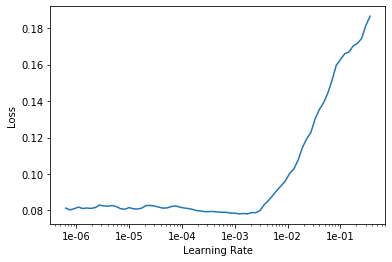

In [35]:
learn.recorder.plot()

In [36]:
lr=1e-4
learn.fit_one_cycle(8, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.079707,0.070037,0.973620,00:15
1,0.076330,0.062876,0.977740,00:15
2,0.068723,0.055216,0.981432,00:15
3,0.061719,0.050174,0.983548,00:15
4,0.055639,0.045962,0.984501,00:15
5,0.052170,0.044645,0.985312,00:15
6,0.049881,0.043805,0.985716,00:15
7,0.047447,0.043615,0.985754,00:15


In [44]:
denorm=learn.data.denorm

In [45]:
with torch.no_grad():
    x,y = next(iter(learn.data.valid_dl))
    yhat = to_np(learn.model(x))
    x=denorm(x)

In [46]:
x.shape, y.shape, yhat.shape

(torch.Size([16, 3, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 (16, 4, 256, 256))

In [47]:
yhat=yhat.argmax(1)

In [48]:
def blend_image_mask(im, mask, alpha=0.7):
    im_mask=np.zeros((im.shape[1], im.shape[2], 3), dtype='float32')
    for j in range(3): im_mask[:,:,j]=im.mean(axis=0)
    for j in range(1, 4):
        im_mask[mask==j] = alpha*im_mask[mask==j] + (1-alpha)*np.array([float(i==(j-1)) for i in range(3)])
    return im_mask

In [49]:
def make_legend():
    custom_lines = [Line2D([0], [0], color='r', lw=2, alpha=0.5),
                    Line2D([0], [0], color='g', lw=2, alpha=0.5),
                    Line2D([0], [0], color='b', lw=2, alpha=0.5)]

    legend(custom_lines, ['Brick', 'Ball', 'Cylinder'])

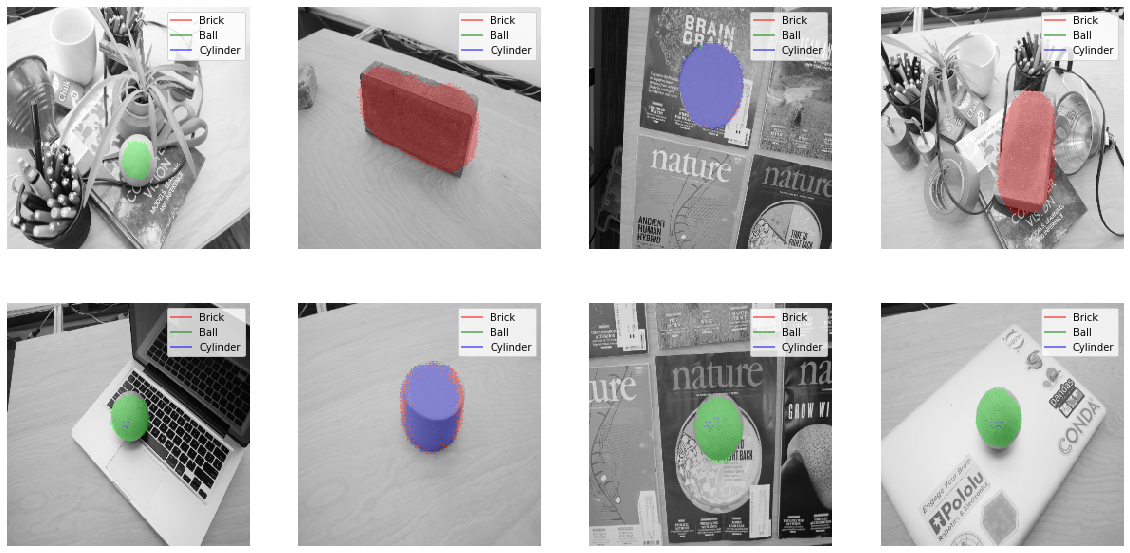

In [50]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()

---

---

## Unet for comparison!

In [51]:
learn2=unet_learner(data, models.resnet18, metrics=pixel_accuracy)

In [52]:
learn2.freeze()

In [53]:
learn2.lr_find()

Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/ubuntu/anaconda3/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: 

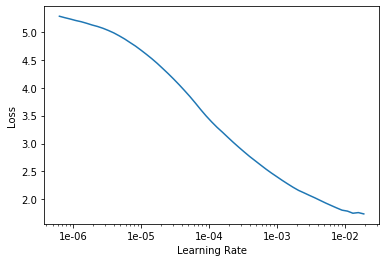

In [79]:
learn2.recorder.plot()

In [54]:
lr=1e-4
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.429264,0.156954,0.947262,01:17
1,0.191191,0.080478,0.975266,01:09
2,0.104421,0.048497,0.984832,01:09
3,0.063750,0.040329,0.986619,01:09


In [55]:
learn2.unfreeze()

In [82]:
learn2.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


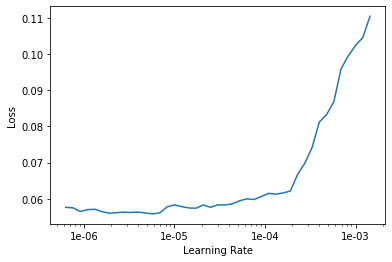

In [83]:
learn2.recorder.plot()

In [ ]:
lr=1e-5
learn2.fit_one_cycle(4, slice(lr/10, lr))

epoch,train_loss,valid_loss,pixel_accuracy,time
0,0.037782,0.036721,0.987524,01:11
1,0.035218,0.032550,0.988374,01:11
2,0.031922,0.031729,0.988692,01:11


In [ ]:
lr=1e-5
learn2.fit_one_cycle(8, slice(lr/10, lr))

In [ ]:
x,y = learn2.data.one_batch()

In [ ]:
with torch.no_grad():
    yhat=learn2.model(x.to('cuda'))

In [ ]:
yhat.shape, yhat.device, yhat.dtype

In [ ]:
y.shape, y.device, y.dtype

In [ ]:
fig=figure(0, (20, 10))

for i in range(8):
    fig.add_subplot(2,4,i+1)
    im_mask=blend_image_mask(x[i], yhat[i])
    imshow(im_mask); axis('off'); make_legend()